# Classifying Urban Sounds using ANN

## 1. Imports

In [1]:
import matplotlib.pyplot as plt

In [2]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

import os

Using TensorFlow backend.


In [3]:
pip install librosa

In [4]:
data = pd.read_csv(r"C:\Users\רועי\data\Urban-Sounds\train\data.csv")

In [5]:
data

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark
...,...,...
5430,8725,engine_idling
5431,8726,dog_bark
5432,8727,engine_idling
5433,8728,engine_idling


## 2. Reading a random audio file to listen to it

In [6]:
i = random.choice(data.ID)
i=100
ipd.Audio("C:\\Users\\רועי\\data\\Urban-Sounds\\train\\Train\\"+str(i)+".wav")

#### Research showed the most important features we can extract from an audio file using librosa which is a great python library for audio

#### Research showed the most important features we can extract from an audio file using librosa which is a great python library for audioFunction to extract the most common audio features from librosa for each sound file. We also added the class label at the end

In [7]:
#  Although this function was modified and many parameteres were explored with, most of it 
# came from Source 8 (sources in the READ.ME)

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath(r"C:\Users\רועי\data\Urban-Sounds\train\Train")+'\\'+str(files.ID)+'.wav')

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.Class

    return mfccs, chroma, mel, contrast, tonnetz, label

In [8]:
from datetime import datetime
# Code to start the timer to see how long it takes to extract the features
startTime = datetime.now()

In [9]:
# Applying the function to the train data by accessing each row of the dataframe
features_labels = data.apply(extract_features, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=785
  n_fft, y.shape[-1]
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=393
  n_fft, y.shape[-1]
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=675
  n_fft, y.shape[-1]
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=953
  n_fft, y.shape[-1]
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=989
  n_f

In [10]:
# Code to see how long it took
print(datetime.now() - startTime)

0:54:56.278656


## 3. We get 4 arrays of numbers, one for each feature

In [11]:
# Checking how the output looks
features_labels

0       ([-82.12359, 139.50592, -42.430866, 24.82786, ...
1       ([-15.744005, 124.119965, -29.42888, 39.447193...
2       ([-123.393654, 15.181949, -50.09333, 7.1418724...
3       ([-213.27881, 89.323586, -55.256187, 12.632097...
4       ([-237.92648, 135.90245, 39.26844, 21.240236, ...
                              ...                        
5430    ([-214.6584, 178.9413, -1.2636192, 63.96227, 6...
5431    ([-395.34592, 105.813354, -0.19629014, -7.0979...
5432    ([-320.81738, 58.300556, -6.8695035, 15.693743...
5433    ([-277.03183, 141.14565, -36.32912, 39.45575, ...
5434    ([-290.99673, 233.35156, -4.6723504, 4.6523294...
Length: 5435, dtype: object

In [12]:
# Saving the numpy array because it takes a long time to extract the features
np.save('features_label', features_labels)

In [13]:
# It takes a long time to extract those features from the files so we will save the results 
# in a dataframe to be able to access them if needed
features_df = pd.DataFrame(features_labels)
features_df.to_csv('features_df.csv', index=False)

In [14]:
# loading the features
features_label = np.load('features_label.npy', allow_pickle=True)

In [15]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_labels)):
    features.append(np.concatenate((features_labels[i][0], features_labels[i][1], 
                features_labels[i][2], features_labels[i][3],
                features_labels[i][4]), axis=0))

In [16]:
len(features)

5435

In [17]:
# Similarly, we create a list where we will store all the labels

labels = []
for i in range(0, len(features_labels)):
    labels.append(features_labels[i][5])

In [18]:
# to let me know when it's done
os.system('say -v Juan ya acabé');

## 4. Checking if we have balanced classes

In [19]:
np.unique(labels, return_counts=True)

(array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
        'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
        'street_music'], dtype='<U16'),
 array([600, 306, 600, 600, 600, 624, 230, 668, 607, 600], dtype=int64))

## 5. Hot encoding y and pre processing X and y

In [20]:
# Setting our X as a numpy array to feed into the neural network
X = np.array(features)

In [21]:
# Setting our y
y = np.array(labels)

In [22]:
y

array(['siren', 'street_music', 'drilling', ..., 'engine_idling',
       'engine_idling', 'air_conditioner'], dtype='<U16')

In [23]:
# Hot encoding y
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [24]:
y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
# Checking our shapes
X.shape

(5435, 193)

In [26]:
# Checking our shapes
y.shape

(5435, 10)

In [27]:
# Choosing the first 3435 files to be our train data
# Choosing the next 1000 files to be our validation data
# Choosing the next 1000 files to be our test never before seen data
# This is analogous to a train test split but we add a validation split and we are making
# we do not shuffle anything since we are dealing with several time series

X_train = X[:3435]
y_train = y[:3435]

X_val = X[3435:4435]
y_val = y[3435:4435]

X_test = X[4435:]
y_test = y[4435:]

## 6. We need to make sure that our splits still contain the proportion of our classes, either balanced or unbalanced (analogous to stratify)

In [28]:
data[:3435]['Class'].value_counts(normalize=True)

jackhammer          0.125182
street_music        0.114410
siren               0.113537
air_conditioner     0.112955
engine_idling       0.112082
drilling            0.109170
dog_bark            0.108006
children_playing    0.106841
car_horn            0.053566
gun_shot            0.044250
Name: Class, dtype: float64

In [29]:
data[3435:4435]['Class'].value_counts(normalize=True)

children_playing    0.131
jackhammer          0.126
engine_idling       0.118
air_conditioner     0.113
dog_bark            0.109
siren               0.104
drilling            0.103
street_music        0.101
car_horn            0.054
gun_shot            0.041
Name: Class, dtype: float64

In [30]:
data[4435:]['Class'].value_counts(normalize=True)

drilling            0.122
engine_idling       0.121
dog_bark            0.120
siren               0.113
jackhammer          0.112
street_music        0.106
children_playing    0.102
air_conditioner     0.099
car_horn            0.068
gun_shot            0.037
Name: Class, dtype: float64

## 7. Checking the shapes, making sure everything is in order

In [31]:
X_train

array([[-8.21235886e+01,  1.39505920e+02, -4.24308662e+01, ...,
        -2.91521498e-02, -7.11028949e-03,  2.57265928e-02],
       [-1.57440052e+01,  1.24119965e+02, -2.94288807e+01, ...,
         6.87284252e-03,  1.40443520e-02,  7.98550273e-04],
       [-1.23393654e+02,  1.51819487e+01, -5.00933304e+01, ...,
         4.99811222e-02, -1.57626074e-02, -1.01183230e-02],
       ...,
       [-3.44769592e+02,  1.25104568e+02, -1.34084797e+01, ...,
         3.42945256e-02, -2.49252621e-03,  1.62411035e-02],
       [-3.44246521e+01,  1.62523605e+02, -5.17691078e+01, ...,
         4.69745817e-03,  1.36493516e-04,  6.52123354e-03],
       [-3.18696320e+02,  1.41641006e+02, -3.52278519e+01, ...,
        -1.30005988e-01, -4.26658004e-02,  1.91399359e-02]])

In [32]:
X_train

array([[-8.21235886e+01,  1.39505920e+02, -4.24308662e+01, ...,
        -2.91521498e-02, -7.11028949e-03,  2.57265928e-02],
       [-1.57440052e+01,  1.24119965e+02, -2.94288807e+01, ...,
         6.87284252e-03,  1.40443520e-02,  7.98550273e-04],
       [-1.23393654e+02,  1.51819487e+01, -5.00933304e+01, ...,
         4.99811222e-02, -1.57626074e-02, -1.01183230e-02],
       ...,
       [-3.44769592e+02,  1.25104568e+02, -1.34084797e+01, ...,
         3.42945256e-02, -2.49252621e-03,  1.62411035e-02],
       [-3.44246521e+01,  1.62523605e+02, -5.17691078e+01, ...,
         4.69745817e-03,  1.36493516e-04,  6.52123354e-03],
       [-3.18696320e+02,  1.41641006e+02, -3.52278519e+01, ...,
        -1.30005988e-01, -4.26658004e-02,  1.91399359e-02]])

In [33]:
X_val.shape

(1000, 193)

In [34]:
y_val.shape

(1000, 10)

## 8. We need to scale all our X splits to have better results

In [35]:
# Scaling
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [36]:
from datetime import datetime
startTime = datetime.now()

## 9. Grid searching over the neural network to find best parameters

In [37]:
def model_func(layer_one_neurons=128, layer_one_dropout=.5, layer_two_neurons=512, 
               layer_two_dropout=.5, layer_three_neurons=128, layer_three_dropout=.5):
    
    model = Sequential()
    
    model.add(Dense(layer_one_neurons,
                    input_shape=(193,),
                          activation='relu'))
    
    model.add(Dropout(layer_one_dropout))
    
    model.add(Dense(layer_two_neurons,
                    activation='relu'))
    
    model.add(Dropout(layer_two_dropout))

    model.add(Dense(layer_three_neurons,
                    activation='relu'))

    model.add(Dropout(layer_three_dropout))

    model.add(Dense(10,
                    activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model


nn = KerasRegressor(model_func, batch_size=512, verbose=2)

params = {
    'epochs': [100],
    'layer_one_neurons': [193],
    'layer_two_neurons': [64, 128],
    'layer_three_neurons': [128, 256],
    'layer_one_dropout': [.25,.5],
    'layer_two_dropout': [.5,.75],
    'layer_three_dropout': [.5,.75]
}
gs = GridSearchCV(nn, param_grid=params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

Epoch 1/100
 - 0s - loss: 2.5049 - accuracy: 0.1236
Epoch 2/100
 - 0s - loss: 2.2352 - accuracy: 0.1830
Epoch 3/100
 - 0s - loss: 2.1426 - accuracy: 0.2175
Epoch 4/100
 - 0s - loss: 1.9961 - accuracy: 0.2672
Epoch 5/100
 - 0s - loss: 1.9284 - accuracy: 0.3070
Epoch 6/100
 - 0s - loss: 1.7919 - accuracy: 0.3585
Epoch 7/100
 - 0s - loss: 1.6915 - accuracy: 0.3996
Epoch 8/100
 - 0s - loss: 1.6222 - accuracy: 0.4284
Epoch 9/100
 - 0s - loss: 1.5161 - accuracy: 0.4568
Epoch 10/100
 - 0s - loss: 1.4742 - accuracy: 0.4799
Epoch 11/100
 - 0s - loss: 1.4348 - accuracy: 0.5052
Epoch 12/100
 - 0s - loss: 1.3481 - accuracy: 0.5406
Epoch 13/100
 - 0s - loss: 1.2750 - accuracy: 0.5607
Epoch 14/100
 - 0s - loss: 1.2376 - accuracy: 0.5716
Epoch 15/100
 - 0s - loss: 1.1943 - accuracy: 0.5895
Epoch 16/100
 - 0s - loss: 1.1638 - accuracy: 0.5961
Epoch 17/100
 - 0s - loss: 1.1241 - accuracy: 0.6183
Epoch 18/100
 - 0s - loss: 1.0977 - accuracy: 0.6345
Epoch 19/100
 - 0s - loss: 1.0700 - accuracy: 0.6410
Ep

{'epochs': 100,
 'layer_one_dropout': 0.25,
 'layer_one_neurons': 193,
 'layer_three_dropout': 0.5,
 'layer_three_neurons': 128,
 'layer_two_dropout': 0.5,
 'layer_two_neurons': 64}

In [38]:
print(datetime.now() - startTime)

0:08:39.817772


In [39]:
os.system('say -v Juan ya acabé');

## 10. Building the neural network using the best parameters

In [40]:
# build a simple dense model with early stopping with softmax for categorical classification
model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [41]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 15
history = model.fit(X_train, y_train, batch_size=256, epochs=200, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Train on 3435 samples, validate on 1000 samples
Epoch 1/200
3435/3435 [==============================] - 0s 87us/step - loss: 2.1574 - accuracy: 0.2405 - val_loss: 1.6804 - val_accuracy: 0.4600
Epoch 2/200
3435/3435 [==============================] - 0s 27us/step - loss: 1.6283 - accuracy: 0.4547 - val_loss: 1.2275 - val_accuracy: 0.6360
Epoch 3/200
3435/3435 [==============================] - 0s 25us/step - loss: 1.2767 - accuracy: 0.5758 - val_loss: 0.9781 - val_accuracy: 0.7070
Epoch 4/200
3435/3435 [==============================] - 0s 31us/step - loss: 1.0732 - accuracy: 0.6515 - val_loss: 0.8638 - val_accuracy: 0.7520
Epoch 5/200
3435/3435 [==============================] - 0s 29us/step - loss: 0.9043 - accuracy: 0.7106 - val_loss: 0.7652 - val_accuracy: 0.7850
Epoch 6/200
3435/3435 [==============================] - 0s 24us/step - loss: 0.8111 - accuracy: 0.7392 - val_loss: 0.6989 - val_accuracy: 0.7950
Epoch 7/200
3435/3435 [==============================] - 0s 36us/step - loss

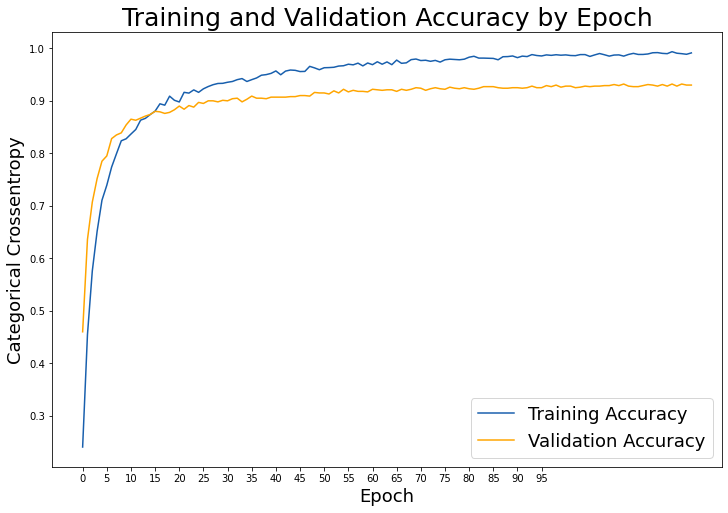

In [42]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [43]:
# Using our model to get the predictions for our test data
preds = model.predict_classes(X_test)

In [44]:
# Looking at our test data as a dataframe to be able to compare prediction values
test = data[4435:]

In [45]:
# Setting our predictions column
test['preds'] = preds

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
# Changing the prediction values to their actual labels
test['preds'] = test['preds'].map({8:'siren', 9:'street_music', 7:'jackhammer',
                   4:'drilling', 3:'dog_bark', 2:'children_playing',
                   6:'gun_shot', 5:'engine_idling', 0:'air_conditioner',
                   1:'car_horn'})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [47]:
# Looking at how accurate our model is just by looking at it
test

,ID,Class,preds
4435,7136,gun_shot,gun_shot
4436,7137,siren,siren
4437,7138,jackhammer,jackhammer
4438,7140,drilling,drilling
4439,7141,air_conditioner,air_conditioner
...,...,...,...
5430,8725,engine_idling,engine_idling
5431,8726,dog_bark,dog_bark
5432,8727,engine_idling,engine_idling
5433,8728,engine_idling,engine_idling


In [48]:
# Slicing our dataframe into the files we got wrong from our predictions
test[test['Class']!=test['preds']]

,ID,Class,preds
4444,7148,siren,children_playing
4465,7178,drilling,gun_shot
4477,7200,dog_bark,children_playing
4522,7265,dog_bark,children_playing
4524,7272,car_horn,drilling
...,...,...,...
5403,8685,drilling,street_music
5407,8694,street_music,drilling
5416,8709,dog_bark,children_playing
5420,8713,dog_bark,children_playing


In [49]:
# Calculating the actual test accuracy
round((1-len(test[test['Class']!=test['preds']])/len(test)),2)

0.93

### We got 93% accuracy in our test data